# 🕵️ Fraud Detection - Insurance Company project

An insurance company hires a team of data scientists to work as consultants in the fraud department. Currently, policies that are issued are monitored and any claims submitted are reviewed and evaluated, manually, to determine legitimacy and final approval for payment by the organization. 

**It is the role of the fraud team to determine which claims submitted should be approved and which should be should be rejected**.

Team's task is to answer the following question: **Are there particular trends in the groups of claims submitted that may be indicative of fraud?**

![insurance-analysis](img/thumbnail.jpg)

---

### Data preview

The finance department has provided them with data on all recent claims made by 1,000 customers. The data is not labeled; that is, there is no variable to tell us which of these claims are fraudulent or not.

Here is a description of what represents each column:

- **case_id**: A unique identifier for each insurance case or claim. This field is likely a numerical value that differentiates one case from another.
- **income**: The annual income of the individual associated with the insurance case. This field is represented as a floating-point number and indicates the financial status of the policyholder.
- **age**: The age of the individual associated with the insurance case. This is an integer value representing how old the person is.
- **sex**: The gender of the individual associated with the insurance case. It is likely represented as 'M' for male and 'F' for female.
- **approval**: The status of the insurance claim. This field indicates whether the claim was "Approved" or "Denied."
- **fraud**: A categorical field indicating whether the insurance claim is under investigation for fraud. It might show values like "No" for non-fraudulent claims and "Under Review" or "Fraud" for those under suspicion.
- **claims**: The monetary amount of the insurance claims made by the individual. This field is a floating-point number representing the total value of the claims. ​

In [1]:
# Importing all the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# use thousand separator (,) for seaborn visualizations
def thousands_formatter(x, pos):
    return f'{x:,.0f}'

# Machine Learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

%matplotlib inline

# Optional: uncomment below code in case you want dark background on plots!
# plt.style.use('dark_background')
# plt.rc_context({'axes.labelcolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'text.color':'white'})

In [2]:
# Obtaining data provided by the finance department

df = pd.read_csv('data/insurance_data_1000.csv')

In [3]:
# preview of the table

df.head()

,case_id,income,age,sex,approval,fraud,claims
0,59982,35750.95,42,M,Approved,Under Review,9518.95
1,87249,24078.27,19,M,Denied,No,19354.23
2,50406,39241.52,37,M,Denied,Fraud,13056.04
3,59391,33248.31,26,M,Approved,No,19238.37
4,96622,38649.96,54,M,Approved,No,14427.42


In [4]:
# How many null values do we have?

df.info()

# no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case_id   1000 non-null   int64  
 1   income    1000 non-null   float64
 2   age       1000 non-null   int64  
 3   sex       1000 non-null   object 
 4   approval  1000 non-null   object 
 5   fraud     1000 non-null   object 
 6   claims    1000 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 54.8+ KB


In [5]:
# How many distinct values do we have on each column?

df.nunique().sort_values(ascending = False)

income      1000
claims      1000
case_id      993
age           69
fraud          3
sex            2
approval       2
dtype: int64

In [6]:
# What are the distinct values for "fraud", "sex" and "approval" columns:

for i in ['age','fraud','sex','approval']:
    print(f'Values inside {i.upper()} column:')
    print(f'{sorted(list(df[i].unique()))}\n')

Values inside AGE column:
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 69, 70, 71, 74, 81, 85, 87, 93, 94, 96]

Values inside FRAUD column:
['Fraud', 'No', 'Under Review']

Values inside SEX column:
['F', 'M']

Values inside APPROVAL column:
['Approved', 'Denied']



In [7]:
# Do we have wrong money amounts? (negative numbers, etc.)

print(df.loc[df.income < 0].income.count())
print(df.loc[df.claims < 0].claims.count())

0
0


Since this is a small and synthetic dataset, there are no null values that we need to take care of.
Also, there are no wrong categories inside categorical fields (fraud, sex and approval), or ages "out of normal range".

We can skip data cleaning process.

### Exploratory Data Analysis 🔎

Before analyzing any tendency available in monetary amounts, we need to confirm what is the distribution of the categorial fields of the data provided:
- In terms of sex, we almost have **equal quantity values of both genders** (507 females and 493 males)
- **79.7% insurance claims were approved**, while 20.3 % were rejected
- **83% of the cases are registered as no fraud**, 11.5 % as fraud, and 5.5 % are under review

In [8]:
# How many individuals do we have per gender?

df.sex.value_counts()

F    507
M    493
Name: sex, dtype: int64

In [9]:
df.approval.value_counts()

Approved    797
Denied      203
Name: approval, dtype: int64

No              830
Fraud           115
Under Review     55
Name: fraud, dtype: int64


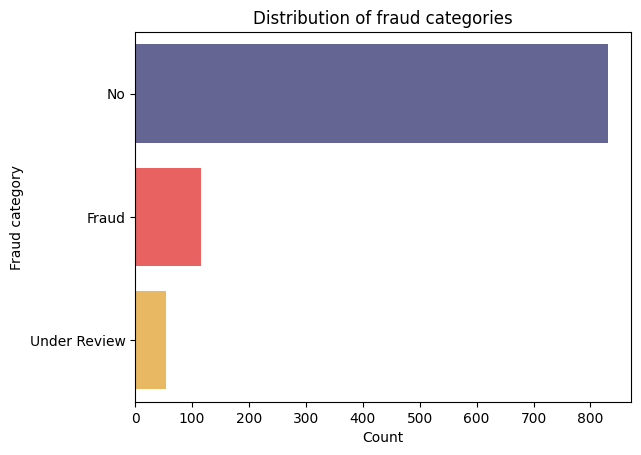

In [10]:
# What is the distribution of the categories?

print(df.fraud.value_counts())

sns.countplot(data = df, y='fraud', order = ['No','Fraud','Under Review'], palette = ['midnightblue','red','orange'], alpha = 0.7)
plt.title('Distribution of fraud categories')
plt.xlabel('Count')
plt.ylabel('Fraud category')
plt.show()

- There are no significant differences in the distributions based on gender.
- We can observe a large group of claims around the income range of 20,000-45,000 (typical income values)
- There is a "strip" of claims with incomes between 45,000-100,000, worthing approximately 5,000 on average claims. It is not quite clear how to describe them, but they could be everyday things that wealthier people can deal with (for example, car accident claims).
- There is another strip of claims for at least 20,000 among people who only earn 10,000, which is unusual and may consist of fraudulent claims.

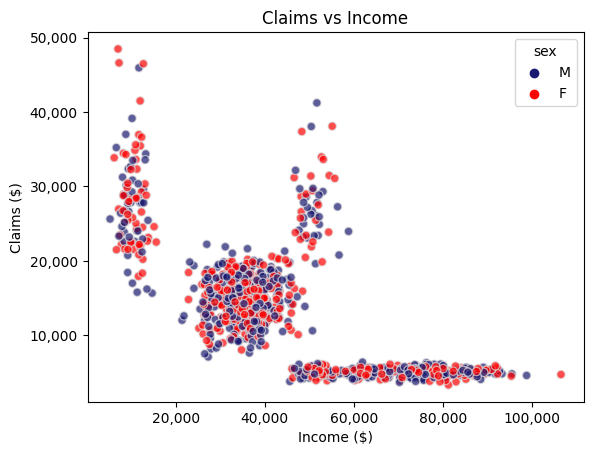

In [11]:
sns.scatterplot(data=df, x='income', y='claims', hue = 'sex', 
                palette = ['midnightblue','red'], alpha = 0.7, edgecolor = '#ddd', linewidth=0.9)
plt.title('Claims vs Income')
plt.xlabel('Income ($)')
plt.ylabel('Claims ($)')

# adding thousand separator format
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show()

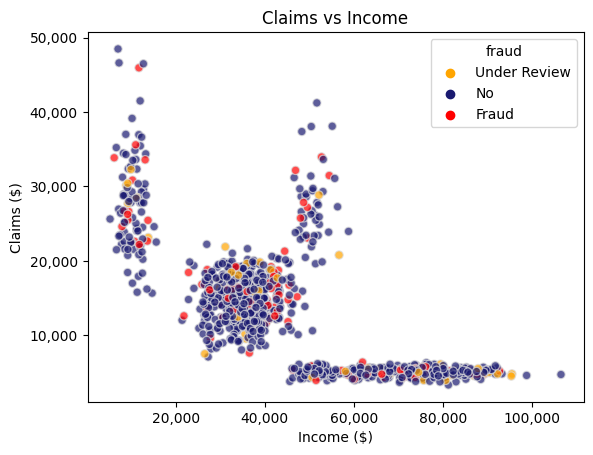

In [12]:
sns.scatterplot(data=df, x='income', y='claims', hue = 'fraud', 
                palette = ['orange','midnightblue','red'], alpha = 0.7, edgecolor = '#ddd', linewidth=0.9)
plt.title('Claims vs Income')
plt.xlabel('Income ($)')
plt.ylabel('Claims ($)')

# adding thousand separator format
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show()

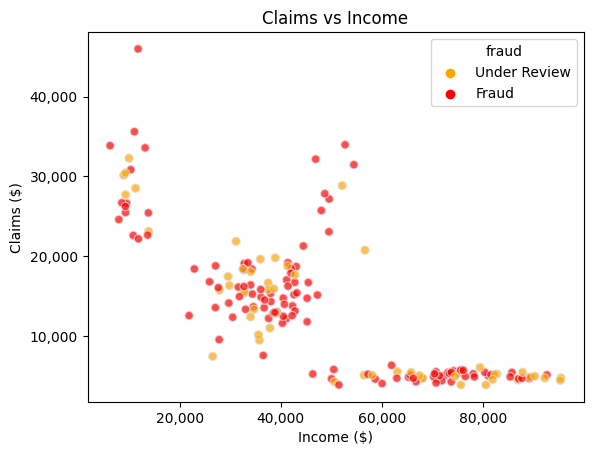

In [13]:
sns.scatterplot(data= df.loc[df.fraud != 'No'], x='income', y='claims', hue = 'fraud', 
                palette = ['orange','red'], alpha = 0.7, edgecolor = '#ddd', linewidth=0.9)
plt.title('Claims vs Income')
plt.xlabel('Income ($)')
plt.ylabel('Claims ($)')

# adding thousand separator format
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show()

- There is a range of people who earn 10,000 at all ages (minimum wage).
- There is a large group of people who earn between 30,000-40,000 at all ages (average salary)
- There are many people with higher incomes (60,000-100,000) just before the age of 60. At the age of 59 is when people in the U.S. can start withdrawing savings from their retirement accounts, so this may have something to do with this pattern.patrón.

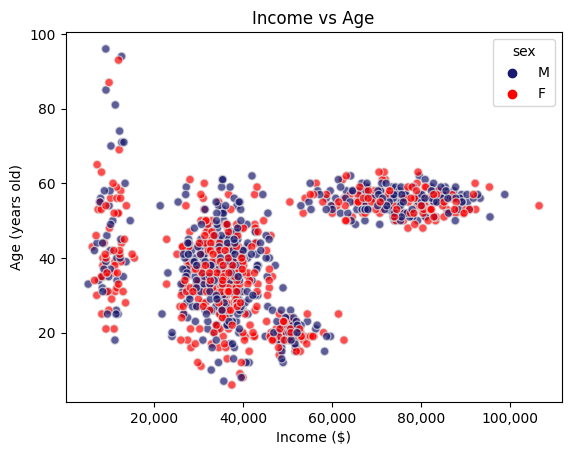

In [14]:
sns.scatterplot(data= df, x='income', y='age', hue = 'sex', 
                palette = ['midnightblue','red'], alpha = 0.7, edgecolor = '#ddd', linewidth=0.9)
plt.title('Income vs Age')
plt.xlabel('Income ($)')
plt.ylabel('Age (years old)')

# adding thousand separator format
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show()

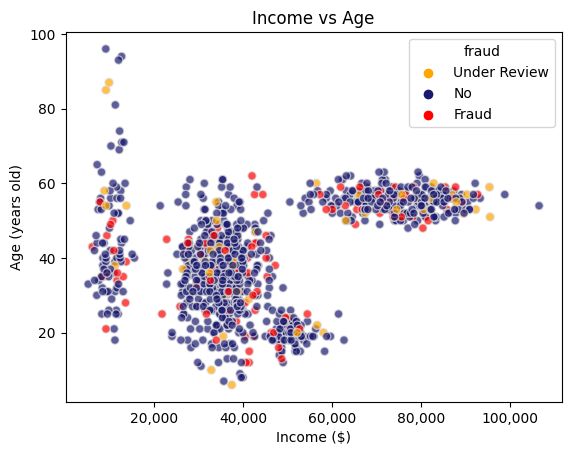

In [15]:
sns.scatterplot(data= df, x='income', y='age', hue = 'fraud', 
                palette = ['orange','midnightblue','red'], alpha = 0.7, edgecolor = '#ddd', linewidth=0.9)
plt.title('Income vs Age')
plt.xlabel('Income ($)')
plt.ylabel('Age (years old)')

# adding thousand separator format
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show()

---
### Data Preprocessing ♻️

Data preprocessing is crucial in machine learning as it directly impacts the outcomes of any algorithm. Machine learning algorithms don't perform well when the input numerical attributes have very different scales. This is why it's better to scaled our data.

For this section we are going to use `MinMaxScaler()`, which is a python library designed for data preprocessing used to normalize or rescale features (numeric variables) to a fixed range, typically 0 to 1, or -1 to 1 if there are negative values in your data.

In [16]:
# saving old dataframe
old_df = df.copy()

# Previewing columns before scaling them
df.head()

,case_id,income,age,sex,approval,fraud,claims
0,59982,35750.95,42,M,Approved,Under Review,9518.95
1,87249,24078.27,19,M,Denied,No,19354.23
2,50406,39241.52,37,M,Denied,Fraud,13056.04
3,59391,33248.31,26,M,Approved,No,19238.37
4,96622,38649.96,54,M,Approved,No,14427.42


In [17]:
# Instantiate scaler
scaler = MinMaxScaler()

In [18]:
# Apply scaler to numeric columns
columns = ['age','income','claims']
df[columns] = scaler.fit_transform(df[columns])

In [19]:
df.head()

,case_id,income,age,sex,approval,fraud,claims
0,59982,0.301264,0.400000,M,Approved,Under Review,0.137252
1,87249,0.185900,0.144444,M,Denied,No,0.355004
2,50406,0.335762,0.344444,M,Denied,Fraud,0.215563
3,59391,0.276530,0.222222,M,Approved,No,0.352439
4,96622,0.329915,0.533333,M,Approved,No,0.245925


For categorical columns, since they are not numerical, we must use another type of data transformation: 

**One-hot encoding** is a process of converting categorical data variables so they can be provided to machine learning algorithms to improve predictions. With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0. Each integer value is represented as a binary vector. 

Thankfully, Scikit-Learn provide us a solution for us if we import `OneHotEncoder()` encoder.


In [20]:
# Instantiate encoder
encoder = OneHotEncoder(sparse_output=False)

In [21]:
# Generate encoded data
columns = ['sex','approval','fraud']

encoded_data = encoder.fit_transform(df[columns])

In [22]:
# Create a dataframe with encoded columns

encoded_df = pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out(columns))
encoded_df.head().astype(int)

,sex_F,sex_M,approval_Approved,approval_Denied,fraud_Fraud,fraud_No,fraud_Under Review
0,0,1,1,0,0,0,1
1,0,1,0,1,0,1,0
2,0,1,0,1,1,0,0
3,0,1,1,0,0,1,0
4,0,1,1,0,0,1,0


In [23]:
# Joining original dataframe with new encoded dataframe
df = df.join(encoded_df.astype(int) )

# dropping old columns
df.drop(columns, axis = 1, inplace = True)

# Preview
df.head()

,case_id,income,age,claims,sex_F,sex_M,approval_Approved,approval_Denied,fraud_Fraud,fraud_No,fraud_Under Review
0,59982,0.301264,0.400000,0.137252,0,1,1,0,0,0,1
1,87249,0.185900,0.144444,0.355004,0,1,0,1,0,1,0
2,50406,0.335762,0.344444,0.215563,0,1,0,1,1,0,0
3,59391,0.276530,0.222222,0.352439,0,1,1,0,0,1,0
4,96622,0.329915,0.533333,0.245925,0,1,1,0,0,1,0


---
### Data Modelling 📝

We are going to train a **k-means clustering algorithm**. K Means is a widely used clustering algorithm in machine learning and data mining. Its goal is to divide a set of data into groups or clusters based on similarities among the data. The "K" in K Means represents the number of clusters that the algorithm should create. Since we preprocess our data, we can create several different models, using N columns. 

**We are going to split dataset into 4 groups, creating a model based on income and claims**. The reason of why I choose income and claims columns only is that, based from the insights from EDA, these are two fields that can explain answer better the question of team need to answer ("Are there particular trends in the groups of claims submitted that may be indicative of fraud?").

Since the purpose of this project is to determine fraudulent claims ourselves, we are going to drop fraud category columns.


In [24]:
# Saving "cleaned" dataframe for future analysis
clean_df = df.copy()

# Transforming dataframe
df = df[['income','claims']]

In [25]:
# Instantiate the ML model
km = KMeans(n_clusters = 4, random_state = 0, n_init = 100)

# n_init = Number of times the k-means algorithm is run with different centroid seeds

In [26]:
# Applying model to dataframe
km.fit(df)

KMeans(n_clusters=4, n_init=100, random_state=0)

In [27]:
# After applying that we can obtain the label of each record, and the centers that KMeans use to determine each group

labels = km.labels_
centers = km.cluster_centers_

print(f'Centers:\n{centers}')

Centers:
[[0.66024437 0.03746097]
 [0.05052828 0.54777631]
 [0.29662732 0.24964085]
 [0.44942999 0.53025166]]


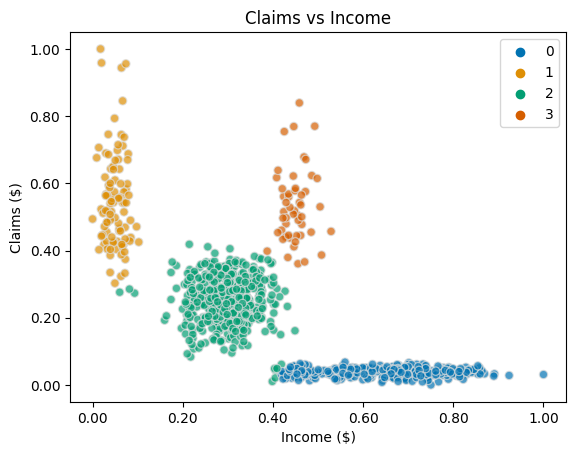

In [30]:
# let's preview what is the splitting based on Income and Claims

def thousands_formatter(x, pos):
    return f'{x:.2f}'

sns.scatterplot(data=df, x='income', y='claims', hue = labels, 
                palette = 'colorblind', alpha = 0.7, edgecolor = '#ddd', linewidth=0.9)
plt.title('Claims vs Income')
plt.xlabel('Income ($)')
plt.ylabel('Claims ($)')

# adding thousand separator format
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show()

So, with this picture, we can determine 4 groups:

- **🔵 Blue group: High income and low claims**. These are likely ordinary claims made by affluent families. It is very likely that these are not fraudulent and that the insurer will accept them.
- **🟢 Green group: Moderate income with moderate claim values**. These are quite abundant and could be everyday items like car claims. They are most likely to be accepted.
- **🟠 Orange group: Moderate income and high claims**. This could be plausible if it's something that middle-income people need but can't always afford, but it is recommended to investigate this further.
- **🟡 Yellow group: Low income but very high claims**. These are clearly not affordable and could be attempts to get free cash. It is recommended to reject these.

---
### Conclusion

On this project we learned the importance of exploring our data before creating a model. Picking the correct or incorrect columns will determine the results of your machine learning model, and this will impact your business or organization sooner or later.

This is not only "running all of the scripts and see what is the result". Understanding the business, thinking outside of the box and being creative are some of the soft skills we need to have to provide a good data visualization, data model, data report or anything inside this area.area.